In [1]:
from IPython.display import display, HTML

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h1 style="color:red;">DI-725 : Transformers and Attention-Based Deep Networks</h1>
  <h2 style="color:red;">Final Project : Phase - 2</h2>
    <h2 style="color:red;">Baseline Model</h2>
  <br><br>
  <h4 style="color:red;">Turgay Yıldız</h4>
  <br>
  <h4 style="color:red;">Graduate School of Informatics, Middle East Technical University (METU)</h4>
</div>

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Fetch big_vision code and install dependencies</h3>
</div>

In [2]:
import os
import sys
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [3]:
# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [4]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [5]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.0 MB/s eta 0:00:00


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model and Pre-trained weights : </h3>
</div>

In [18]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["..."]      =    '...'
os.environ["..."]      =    '...' 

In [19]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [20]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

In [21]:
# Use these for PaliGemma 1:
LLM_VARIANT   = "gemma_2b"
MODEL_PATH    = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

In [22]:
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [23]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !wget https://storage.googleapis.com/big_vision/paligemma_tokenizer.model -O {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Core Library Imports : </h3>
</div>

In [24]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Reserve GPU/TPU for JAX </h3>
</div>

In [25]:
# Don't let TF use the GPU or TPUs
# Disables TensorFlow’s access to GPUs/TPUs so JAX can fully utilize them without resource contention.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

INFO:2025-05-13 11:54:51,294:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-13 11:54:51,307:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


JAX version:  0.5.2
JAX platform: gpu
JAX devices:  2


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Construct model and load params into RAM </h3>

 <h5 style="color:red;"> model_config: hyperparameters for both the vision encoder and text decoder.
<br>
                          Instantiate the combined Vision+LLM model.
<br>
                          Load pretrained weights into a parameter tree.
<br>
                          Build a decode function for efficient batched generation.
                          </h5>


</div>

In [26]:
# Define model

model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

In [27]:
model     = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

In [28]:
# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

In [29]:
tokenizer.eos_id()

1

In [30]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> All parameters are freezed. This is baseline.   </h3>
<br>
</h5>
</div>

In [31]:
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return False
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sharding & Casting Parameters :  </h3>

  <h5 style="color:red;">  Sharding: split tensors across devices (if you had >1 GPU).
<br>
                        maybe_cast_to_f32: keep the frozen weights in fp16 to save memory; cast the few trainable ones to fp32 so their gradients remain stable.
<br>
                        The loop unpacks the parameter tree, reshares & casts each leaf, and reassembles it.
</h5>
</div>


In [32]:
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

In [33]:
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

In [34]:
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

In [35]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [36]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [37]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef  = jax.tree.flatten(params)
sharding_leaves  = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)

for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

In [38]:
# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


In [39]:
#print(" == Model params == ")
#parameter_overview(params)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define preprocess functions to create inputs to the model :  </h3>
</div>

In [40]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Import Data  :  </h3>
</div>

In [41]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np

In [42]:
captions_df = pd.read_csv('/kaggle/input/rsics-dataset/captions.csv')
print(captions_df.head())

  source split           image  \
0   NWPU  test  NWPU_31430.jpg   
1   NWPU  test  NWPU_31431.jpg   
2   NWPU  test  NWPU_31432.jpg   
3   NWPU  test  NWPU_31433.jpg   
4   NWPU  test  NWPU_31434.jpg   

                                           caption_1  \
0   A gray plane on the runway and the lawn beside .   
1  Three small planes parked in a line on the air...   
2  A plane parked in a line on the airport with s...   
3  A small plane and a big plane parked next to b...   
4       Two planes parked next to boarding bridges .   

                                           caption_2  \
0        A grey plane is on the runway by the lawn .   
1  There are four aircraft on the open ground, Th...   
2  A white plane was parked on the instruction li...   
3  A white plane and a gray plane parked at the b...   
4  Two aircraft were parked at the departure gates .   

                                           caption_3  \
0  There is an airplane on the runway with a larg...   
1  There 

In [43]:

IMAGE_ROOT = "/kaggle/input/rsics-dataset/resized"
BATCH_SIZE = 32
IMG_SIZE   = (224, 224)

In [44]:
print("All split labels:", captions_df['split'].unique())
print("Counts:\n", captions_df['split'].value_counts())

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [45]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = captions_df[captions_df['split'] == split_name]

In [46]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions

In [47]:
train_paths, train_caps = df_to_paths_and_captions(splits['train'])
val_paths,   val_caps   = df_to_paths_and_captions(splits['val'])
test_paths,  test_caps  = df_to_paths_and_captions(splits['test'])

In [48]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
         )
    return ds

In [49]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=True)
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False)

In [50]:
# 8. Quick sanity check
for imgs, caps in test_ds.take(1):
    print("Images batch shape:", imgs.shape)            # (BATCH_SIZE, H, W, 3)
    print("Captions batch shape:", len(caps), "examples")
    print("First example captions:", caps[0])            # a list of 5 strings

Images batch shape: (32, 224, 224, 3)
Captions batch shape: 32 examples
First example captions: tf.Tensor(
[b'A gray plane on the runway and the lawn beside .'
 b'A grey plane is on the runway by the lawn .'
 b'There is an airplane on the runway with a large lawn by the runway .'
 b'A plane is parked on the runway next to the grass .'
 b'There is a plane on the runway beside the grass .'], shape=(5,), dtype=string)


In [51]:
def train_data_iterator():
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                # Decode all 5 captions into Python strings
                decoded_caps = [c.decode('utf-8') for c in caps]

                # Prepare the model input from a random caption
                suffix = decoded_caps[np.random.randint(5)].lower()
                prefix = "caption en"

                tokens, mask_ar, mask_loss, _ = preprocess_tokens(
                    prefix, suffix, SEQLEN
                )

                img_proc = img * 2.0 - 1.0
                yield [{
                    "image":     img_proc,
                    "text":      np.asarray(tokens,    dtype=np.int32),
                    "mask_ar":   np.asarray(mask_ar,    dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss,  dtype=np.int32),
                },
                    decoded_caps,
                      ]

#----------------------------------------------------------------------------------------------------------------#
#                                              Validation :
#----------------------------------------------------------------------------------------------------------------#
def validation_data_iterator():
    """Single-pass iterator over validation examples from val_ds."""
    for image_batch, caps_batch in val_ds:

         images_np = image_batch.numpy()
         caps_np   = caps_batch.numpy()

         for img, caps in zip(images_np, caps_np):

            decoded_caps =   [c.decode('utf-8') for c in caps]
            suffix       =   decoded_caps[np.random.randint(5)].lower()
            prefix       =   "caption en"

            tokens, mask_ar, _, mask_input = preprocess_tokens(
                 prefix,  seqlen=SEQLEN)

            img_proc = img * 2. - 1.
            yield [{
                 "image":     img_proc,
                 "text":      np.asarray(tokens,     dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
                 "mask_ar":    np.asarray(mask_ar,    dtype=np.int32),
            },
                 decoded_caps,
                  ]


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Check Iterators :  </h3>
</div>

In [52]:
SEQLEN  =  128

In [ ]:
val_it = validation_data_iterator()

for _ in range(1):
    ex   = next(val_it)

In [ ]:
ex[0]["image"].shape,   ex[0]["text"].shape,  ex[0]["mask_input"].shape,   ex[0]["mask_ar"].shape

((224, 224, 3), (128,), (128,), (128,))

In [ ]:
ex[1]

['Three planes parked on the airport and a white buildings in front of planes .',
 'Three white planes parked in the open space .',
 'There are many planes of the same size in a clearing, With many containers next to the plane .',
 'Three planes are parked on the open space next to the bare land .',
 'Three planes are on the marked ground .']

In [ ]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


In [ ]:
import html


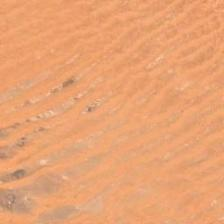
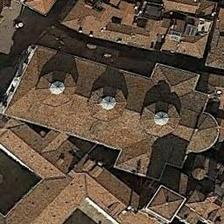
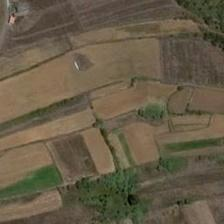
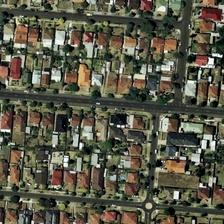

In [ ]:
html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    img = example[0]["image"]

    html_out += render_example(img, example[1][0])
    # optionally a divider between images:
    html_out += "<hr style='width:100%;'>"

display(HTML("<h3>Training examples </h3>" + html_out))


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define the training step and evaluation loop :  </h3>
</div>

In [53]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss
#---------------------------------------------------------------------------------------------------------#
#                                     Evaluation/inference loop.
#---------------------------------------------------------------------------------------------------------#
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    captions = []
    try:
#---------------------------------------------------------------------------------------------------------#
      for _ in range(batch_size):

        example, caps   = next(data_iterator)
        example["_mask"]  = np.array(True)
        examples.append(example)
        captions.append(caps)
#---------------------------------------------------------------------------------------------------------#
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.
      captions.append(captions[-1])  # pad suffix list accordingly
#---------------------------------------------------------------------------------------------------------#
    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)
#---------------------------------------------------------------------------------------------------------#
    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)
#---------------------------------------------------------------------------------------------------------#
    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]
#---------------------------------------------------------------------------------------------------------#
    # Only include non-padded outputs
    for example, response, caps in zip(examples, responses, captions):
        if example["_mask"]:
          outputs.append((example["image"], response, caps))
          if num_examples and len(outputs) >= num_examples:
            return outputs

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Check the predictions :  </h3>
</div>

In [ ]:
(example, caps) = next(validation_data_iterator())

In [ ]:
img, pred, ref = make_predictions(iter([(example, caps)]),
                                  num_examples=1,
                                  batch_size=1)[0]

In [ ]:
print("PRED:", pred)
print("REF:", ref)

PRED: oil is a big business here .
REF: ['Here are four black storage tanks of the same size .', 'There are several neatly arranged large oil storage tanks in the factory, And a river outside the factory .', 'There are four white storage tanks on the bare land .', 'There is grass beside the storage tanks .', 'There are several storage tanks of different sizes .']


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> WANDB :  </h3>
</div>

In [54]:
import wandb

In [55]:
os.environ["..."]       =      "..."

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Evaluate :  </h3>
</div>

In [ ]:
run  =  wandb.init(project="...", entity="...")

In [ ]:
#import multiprocessing as mp
#mp.set_start_method("spawn", force=True)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 99%|█████████▉| 79/80 [00:32<00:00,  2.40it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



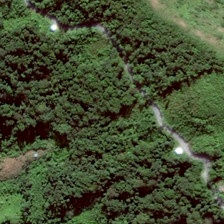
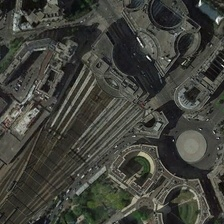
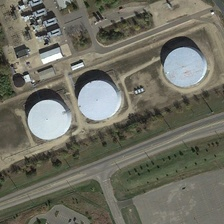
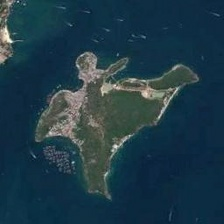

 99%|█████████▉| 79/80 [00:31<00:00,  2.49it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



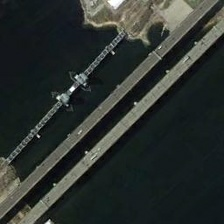
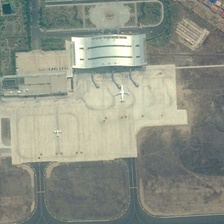
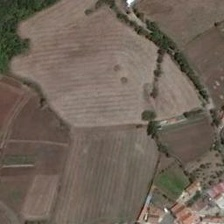
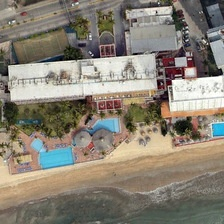

 99%|█████████▉| 79/80 [00:32<00:00,  2.45it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



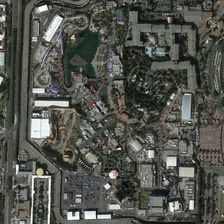
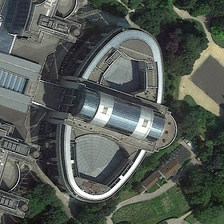
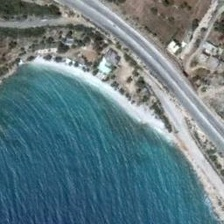
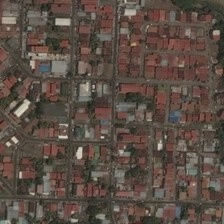

 99%|█████████▉| 79/80 [00:32<00:00,  2.45it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



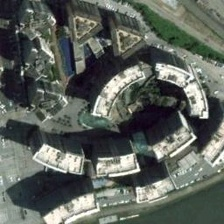
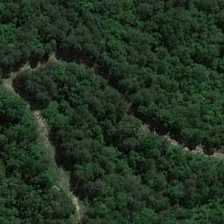
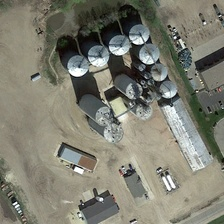
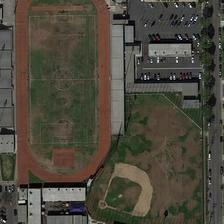

 99%|█████████▉| 79/80 [00:32<00:00,  2.46it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



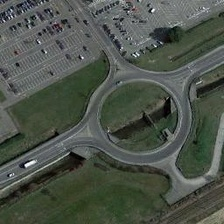
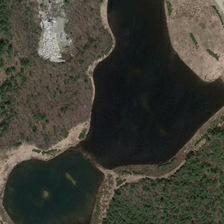
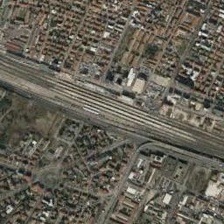
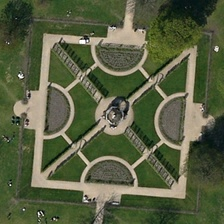

 99%|█████████▉| 79/80 [00:32<00:00,  2.46it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



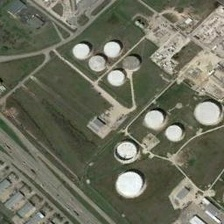
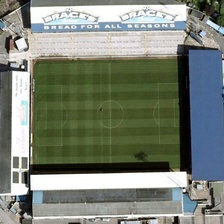
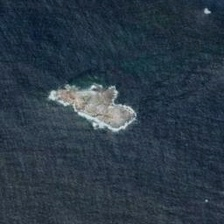
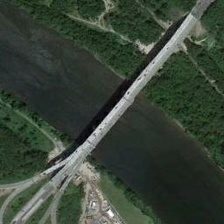

 99%|█████████▉| 79/80 [00:32<00:00,  2.46it/s]


   BLEU:   0.000
   ROUGE1: 0.090, ROUGE2: 0.017, ROUGEL: 0.081
   METEOR: 0.031



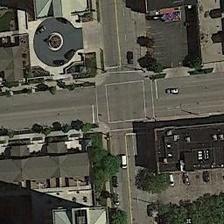
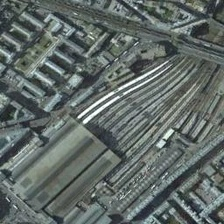
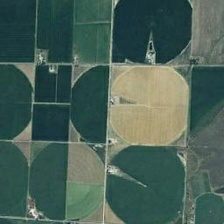
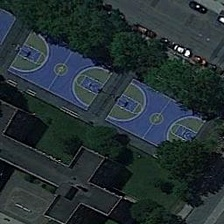

 50%|█████     | 40/80 [00:15<00:15,  2.56it/s]

In [ ]:
import io, base64
from PIL import Image
from IPython.display import HTML, display

import wandb
import pickle
import evaluate
from tqdm import tqdm
#---------------------------------------------------------------------------------------------------------------------------#
# 1) Install & load metrics
#    pip install evaluate
bleu_metric   = evaluate.load("bleu")
rouge_metric  = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
#---------------------------------------------------------------------------------------------------------------------------#
# 2) Hyperparams
BATCH_SIZE     = 8
LEARNING_RATE  = 0.0001

#---------------------------------------------------------------------------------------------------------------------------#
#run = wandb.init(project="DI_725_Project_Phase_2__2697258", reinit=True, settings=wandb.Settings(init_timeout=500))


run.config.update({
    "model_name"     : "PaliGemma Baseline",
    "batch_size"     : BATCH_SIZE,
    "learning_rate"  : LEARNING_RATE,
    "seq_len"        : 128
})

#---------------------------------------------------------------------------------------------------------------------------#
#                                         ——— eval step ———
#---------------------------------------------------------------------------------------------------------------------------#
# A) Batch‐collect all validation examples once
all_examples = []
all_captions = []

val_it = validation_data_iterator()

num_to_eval = 80

for epoch in tqdm(range(10)):   
    
    for _ in range(num_to_eval):
        example, caps = next(val_it)
    
        all_examples.append(example)
        all_captions.append(caps)
    
    # B) One big make_predictions call
    #    This internally pads to multiples of batch_size as needed.
    
    demo_outputs = make_predictions(
        iter((zip(all_examples, all_captions), total=num_to_eval)),
        num_examples = num_to_eval,
        batch_size   = BATCH_SIZE,
    )
    
    
    # demo_outputs is a list of (img, pred, ref) of length num_to_eval
    all_hyps = [pred for (_, pred, _) in demo_outputs]
    all_refs = [[ref] for (_, _, ref) in demo_outputs]
    
    #---------------------------------------------------------------------------------------------------------------------------#
    #                                          compute & log BLEU/ROUGE/METEOR …
    #---------------------------------------------------------------------------------------------------------------------------#
    # 1) Filter out any fully empty predictions
    # Filter out any empty predictions, just in case
    filtered = [(h, refs) for h, refs in zip(all_hyps, all_refs) if h.strip()]
    if filtered:
        all_hyps, all_refs = zip(*filtered)
        all_hyps, all_refs = list(all_hyps), list(all_refs)
    else:
        all_hyps, all_refs = [], []
    
    # Only call metrics if we have at least one example
    if all_hyps:
        bleu_res = bleu_metric.compute(
            predictions=all_hyps,
            references=all_refs,
            smooth=True   # avoid zero‐div errors
        )
        rouge_res = rouge_metric.compute(
            predictions=all_hyps,
            references=all_refs
        )
        meteor_res = meteor_metric.compute(
            predictions=all_hyps,
            references=all_refs
        )
    else:
        # no valid hyps → set everything to zero
        bleu_res   = {"bleu": 0.0}
        rouge_res  = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
        meteor_res = {"meteor": 0.0}
    
    print(f"   BLEU:   {bleu_res['bleu']:.3f}")
    print(f"   ROUGE1: {rouge_res['rouge1']:.3f}, ROUGE2: {rouge_res['rouge2']:.3f}, ROUGEL: {rouge_res['rougeL']:.3f}")
    print(f"   METEOR: {meteor_res['meteor']:.3f}")
    
    wandb.log({
        "eval/bleu":    bleu_res["bleu"],
        "eval/rouge1":  rouge_res["rouge1"],
        "eval/rouge2":  rouge_res["rouge2"],
        "eval/rougeL":  rouge_res["rougeL"],
        "eval/meteor":  meteor_res["meteor"],
    }, step=epoch) 
    
    #---------------------------------------------------------------------------------------------------------------------------#
    #                        ---- B) Demo‐sample pass via make_predictions ----
    #---------------------------------------------------------------------------------------------------------------------------#
    demo_samples = make_predictions(
        validation_data_iterator(),
        num_examples=4,
        batch_size=4,
    )
    
    # now demo_samples is a list of (img, pred, ref)
    #---------------------------------------------------------------------------------------------------------------------------#
    #                         ---- Display side‐by‐side in Colab ----
    #---------------------------------------------------------------------------------------------------------------------------#
    
    html = "<div style='display:flex; gap:16px;'>"
    for img, pred, ref in demo_samples:
        img_u8 = ((img + 1) * 127.5).astype("uint8")
        buf    = io.BytesIO()
        Image.fromarray(img_u8).save(buf, format="PNG")
        b64    = base64.b64encode(buf.getvalue()).decode("utf-8")
        html += f"""
          <div style='text-align:center;'>
            <img src="data:image/png;base64,{b64}" width="200"/><br/>
            <strong>Pred:</strong> {pred}<br/>
            <strong>Ref:</strong> {ref}
          </div>
        """
    html += "</div>"
    display(HTML(html))
    #---------------------------------------------------------------------------------------------------------------------------#
    # ---- D) W&B table ----
    #---------------------------------------------------------------------------------------------------------------------------#
    table = wandb.Table(columns=["image","predicted","reference"])
    for img, pred, ref in demo_samples:
        wb_img = wandb.Image(((img + 1) * 127.5).astype("uint8"))
        table.add_data(wb_img, pred, ref)
    wandb.log({"eval/samples_table": table}, step=epoch) 
#---------------------------------------------------------------------------------------------------------------------------#

wandb.finish()
